Step 1: Import Necessary Libraries



In [1]:
!pip install scipy==1.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4


In [2]:
from keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import Callback
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import entropy
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import save_model
import cv2 # Import OpenCV

In [3]:
import random

seed = 42

# Python's built-in random library
random.seed(seed)

# Scikit-learn (only affects some parts of scikit-learn)
from sklearn.utils import check_random_state
check_random_state(seed)

np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

Step 2: Load and Preprocess the Data



In [4]:
img_rows = 168
img_cols = 168
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

In [5]:
# Set path for data source
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Load Diffusion/dataset/")

Mounted at /content/gdrive


In [6]:
# Set the path to the folder containing saved files
load_path = "./preprocessed_data_168x168_2years"

# Load saved NumPy arrays
X_train = np.load(os.path.join(load_path, 'X_train.npy'))
X_test = np.load(os.path.join(load_path, 'X_test.npy'))
y_train = np.load(os.path.join(load_path, 'y_train.npy'))
y_test = np.load(os.path.join(load_path, 'y_test.npy'))

# Load saved Pandas DataFrames
train_data = pd.read_pickle(os.path.join(load_path, 'train_data.pkl'))
test_data = pd.read_pickle(os.path.join(load_path, 'test_data.pkl'))
metadata = pd.read_pickle(os.path.join(load_path, 'metadata.pkl'))
metadata_original = pd.read_pickle(os.path.join(load_path, 'metadata_original.pkl'))

In [7]:
def merge_dummified_columns(df, dummified_columns, new_column_name):
    """
    Merges dummified columns into a single column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the dummified columns.
        dummified_columns (list): A list of the names of the dummified columns.
        new_column_name (str): The name of the new column to create.

    Returns:
        pd.DataFrame: The DataFrame with the dummified columns merged into a single new column.
    """
    # Create a new column containing the column name where the value is 1 for each row
    df[new_column_name] = df[dummified_columns].idxmax(axis=1)

    # Drop the dummified columns
    df.drop(dummified_columns, axis=1, inplace=True)

    return df

test_metadata = metadata_original.loc[test_data.columns]

test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['chilledwater', 'electricity', 'gas', 'hotwater', 'steam'],
                     new_column_name='meter_type')
test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['Education', 'Entertainment/public assembly', 'Lodging/residential', 'Office', 'Public services'],
                     new_column_name='building_type')

test_metadata


,lat,lng,year,meter_type,building_type
electricity_Lamb_office_Caitlin_2016,51.497838,-3.186246,2016,electricity,Office
electricity_Rat_public_Kelle_2016,38.903504,-77.005349,2016,electricity,Public services
electricity_Rat_assembly_Ezequiel_2016,38.903504,-77.005349,2016,electricity,Entertainment/public assembly
electricity_Bear_assembly_Roxy_2016,37.871903,-122.260729,2016,electricity,Entertainment/public assembly
gas_Shrew_office_Rose_2017,51.499840,-0.124663,2017,gas,Office
...,...,...,...,...,...
steam_Moose_education_Omar_2016,45.421500,-75.697200,2016,steam,Education
electricity_Rat_public_Chrissy_2017,38.903504,-77.005349,2017,electricity,Public services
electricity_Hog_office_Merilyn_2016,44.978782,-93.255398,2016,electricity,Office
steam_Bull_assembly_Amalia_2016,30.267200,-97.743100,2016,steam,Entertainment/public assembly


In [8]:
X_train = tf.image.resize(X_train, [img_rows, img_cols]).numpy()
X_test = tf.image.resize(X_test, [img_rows, img_cols]).numpy()

In [9]:
X_train.max(),X_train.min()

(1.0, -1.0)

In [10]:
X_train = (X_train+1)/2
X_test = (X_test+1)/2

In [11]:
X_train.max(),X_train.min()

(1.0, 0.0)

In [12]:
X_train.shape

(2702, 168, 168, 1)

In [13]:
X_test.shape

(901, 168, 168, 1)

In [14]:
y_train.shape

(2702, 13)

In [15]:
y_test.shape

(901, 13)

In [16]:
metadata_test = metadata.loc[test_data.columns]

Step 3: Define the CVAE Architecture



In [17]:
dense_dims = 64
vae_dim = 512 #256

# Encoder
inputs = Input(shape=(img_rows, img_cols, 1))
labels = Input(shape=(y_test.shape[1],))
x = Conv2D(16, 3, activation='relu')(inputs)
x = Conv2D(32, 3, activation='relu')(inputs)
x = Conv2D(64, 3, activation='relu')(x)
x = Flatten()(x)
x = Dense(dense_dims, activation='relu')(x)
concat = K.concatenate([x, labels], axis=1)
mu = Dense(vae_dim)(concat)
log_var = Dense(vae_dim)(concat)
encoder = Model([inputs, labels], [mu, log_var])

# Sampling function
def sampling(args):
    mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
    return mu + K.exp(log_var / 2) * epsilon

z = sampling([mu, log_var])

# Decoder
decoder_input = Input(shape=(vae_dim + y_test.shape[1],))  # Concatenated z and labels
x = Dense(dense_dims, activation='relu')(decoder_input)
x = Dense(int(img_rows/8) * int(img_cols/8) * 128, activation='relu')(x)
x = Reshape((int(img_rows/8) , int(img_cols/8), 128))(x)
x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
decoded = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, decoded)

z_and_labels = K.concatenate([z, labels], axis=1)
outputs = decoder(z_and_labels)
vae = Model([inputs, labels], outputs)

In [18]:
def generate_digits(rows):
  # Number of columns (fixed at 10 for 10 digits)
  cols = 5
  rows = 2

  # Total number of samples
  n_samples = rows * cols

  labels_to_condition = y_test[:n_samples]

  # Sample random points in the latent space
  random_latent_points = np.random.normal(size=(n_samples, vae_dim))

  # Concatenate the latent points with the one-hot encoded labels
  latent_and_labels = np.concatenate([random_latent_points, labels_to_condition], axis=1)

  # Decode the latent and label points to generate images
  generated_images = decoder.predict(latent_and_labels)

  # Plot the generated images in a grid with specified rows and 10 columns
  fig, axes = plt.subplots(rows, cols, figsize=(10, 1.5 * rows))

  display(metadata_test.iloc[:n_samples])
  for i in range(rows):
      for j in range(cols):
          # First, squeeze to remove the channel dimension
          image = generated_images[i * cols + j, :, :, 0].squeeze()

          # Resize image to be square (100x100) using OpenCV
          resized_image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)

          axes[i, j].imshow(resized_image, cmap='gray')
          axes[i, j].axis('off')

  plt.show()
  print(generated_images.max(),generated_images.min())


Step 4: Define the Loss Function and Compile the Model



In [19]:
# Loss function
reconstruction_loss = K.sum(K.square(inputs - outputs), axis=[1, 2, 3])  # Using MSE instead of binary cross-entropy
#reconstruction_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=[1, 2, 3])
kl_loss = - 0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [20]:
# Compile and train
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Step 5: Train the Model



In [21]:
#vae.fit([X_train, y_train], epochs=10, batch_size=32, validation_data=([X_test, y_test], None))

In [23]:
def calculate_fid(model, images1, images2):
    # Calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Compute the sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Compute the square root of the product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Compute the FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def preprocess_real_images(images, shape_size):

    # Ensure the images are in the shape (batch_size, shape_size[0], shape_size[1], 1) as required
    processed_images = tf.image.resize(images, shape_size, method=tf.image.ResizeMethod.BILINEAR)

    # Stack the single channel image into three channels
    processed_images = np.repeat(processed_images, 3, axis=-1)

    return processed_images

In [24]:
n_samples = X_test.shape[0]

class GenerateDigitsCallback(Callback):
    def __init__(self, rows=5):
        self.rows = rows

    def on_epoch_end(self, epoch, logs=None):
        generate_digits(self.rows)
        print("\n")  # Add a newline to separate the plots from the training log

class ComputeFIDCallback(Callback):
    def __init__(self, patience=5):
        self.best_fid_score = float('inf')
        self.patience = patience
        self.epochs_without_improvement = 0

    def on_epoch_end(self, epoch, logs=None):
        # Generate the images as you've done before
        labels_to_condition = np.array([i % 10 for i in range(n_samples)])
        labels_one_hot = to_categorical(labels_to_condition, y_test.shape[1])
        random_latent_points = np.random.normal(size=(n_samples, vae_dim))
        latent_and_labels = np.concatenate([random_latent_points, labels_one_hot], axis=1)
        generated_images = decoder.predict(latent_and_labels)

        # Preprocess real and generated images
        real_images = preprocess_real_images(X_test, (75,75))
        generated_images = preprocess_real_images(generated_images, (75,75))

        # Compute FID
        fid_score = calculate_fid(inception_model, real_images, generated_images)

        # Print FID Score
        print('FID Score at end of epoch {}: {}'.format(epoch, fid_score))

        # Check for improvement
        if fid_score < self.best_fid_score:
            self.best_fid_score = fid_score
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        # Stop training if the tolerance is exceeded
        if self.epochs_without_improvement >= self.patience:
            print('Stopping training due to lack of improvement in FID score.')
            self.model.stop_training = True

        # Store FID score in logs to be recorded in history
        logs['fid_score'] = fid_score

class ModelCheckpointCallback(Callback):
    def __init__(self, decoder, save_path='./weights_168x168'):
        self.decoder = decoder
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Save the model at the end of each epoch
        save_model(self.decoder, f"{self.save_path}/cvae_mse_epoch_{epoch+1}.keras")
        print(f"Model saved: {self.save_path}/cvae_mse_epoch_{epoch+1}.keras")

# Create instances of all callbacks
generate_digits_callback = GenerateDigitsCallback(rows=3)
compute_fid_callback = ComputeFIDCallback(patience=10)
model_checkpoint_callback = ModelCheckpointCallback(decoder=decoder)

# Make sure the directory exists
import os
if not os.path.exists('./weights_168x168'):
    os.makedirs('./weights_168x168')

# Train the model with all callbacks
history = vae.fit([X_train, y_train],
                  epochs=100,
                  batch_size=64,
                  validation_data=([X_test, y_test], None),
                  callbacks=[generate_digits_callback, model_checkpoint_callback])


Output hidden; open in https://colab.research.google.com to view.

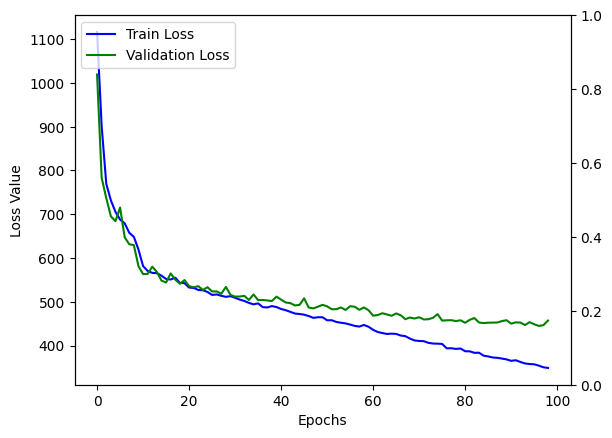

In [25]:

# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot training loss
ax1.plot(history.history['loss'][1:], label='Train Loss', color='b')

# Plot validation loss
ax1.plot(history.history['val_loss'][1:], label='Validation Loss', color='g')

# Label the first y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss Value')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot FID score on the second y-axis
#ax2.plot(history.history['fid_score'], label='FID Score', color='r')

# Label the second y-axis
#ax2.set_ylabel('FID Score')
#ax2.legend(loc='upper right')

plt.show()


1/1 [==============================] - 0s 27ms/step


,lat,lng,chilledwater,electricity,gas,hotwater,steam,Education,Entertainment/public assembly,Lodging/residential,Office,Public services,year
electricity_Lamb_office_Caitlin_2016,0.925421,0.926498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
electricity_Rat_public_Kelle_2016,0.418241,0.352124,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
electricity_Rat_assembly_Ezequiel_2016,0.418241,0.352124,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
electricity_Bear_assembly_Roxy_2016,0.376698,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
gas_Shrew_office_Rose_2017,0.925501,0.950320,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
electricity_Lamb_assembly_Cherie_2017,0.925421,0.926498,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
electricity_Rat_education_Nellie_2017,0.418241,0.352124,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
chilledwater_Bull_education_Miquel_2017,0.070454,0.190767,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
hotwater_Fox_lodging_Stephen_2016,0.197596,0.080396,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
electricity_Rat_assembly_Damaris_2017,0.418241,0.352124,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


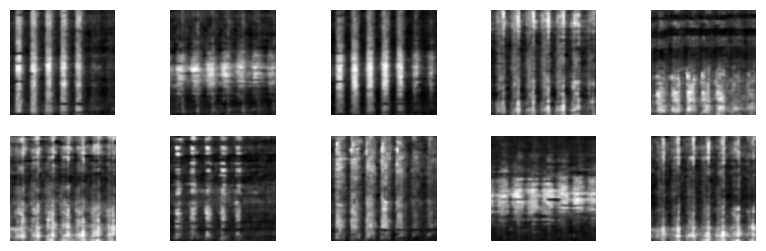

0.7629664 0.0069649527


In [26]:
generate_digits(rows=5)